In [29]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from pandas.plotting import lag_plot
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import scipy.optimize as opt
import math

from math import sqrt
from sklearn.metrics import mean_squared_error

import yfinance as yf

We are converting Date into column here

In [14]:
start_date = datetime(2017,1,1)
end_date = datetime(2022,1,1)
NVR = yf.download('NVR',start_date ,end_date)
Y = NVR['Adj Close'].values
NVR["Date"] = NVR.index
NVR = NVR[["Date", "Open", "High", 
             "Low", "Close", "Adj Close", "Volume"]]
NVR.reset_index(drop=True, inplace=True)
print(NVR.head())


[*********************100%***********************]  1 of 1 completed
        Date         Open         High          Low        Close    Adj Close  \
0 2017-01-03  1650.000000  1665.000000  1631.780029  1649.989990  1649.989990   
1 2017-01-04  1654.000000  1686.520020  1645.030029  1678.770020  1678.770020   
2 2017-01-05  1676.199951  1690.829956  1671.510010  1689.400024  1689.400024   
3 2017-01-06  1684.010010  1697.479980  1675.010010  1678.099976  1678.099976   
4 2017-01-09  1680.800049  1689.000000  1666.550049  1681.500000  1681.500000   

   Volume  
0   37400  
1   22500  
2   24200  
3   23400  
4   17100  


In [15]:
NVR['Typical_Price'] = NVR[['High','Low','Close']].mean(axis=1)
NVR['lrets'] = (np.log(NVR.Close) - np.log(NVR.Close.shift(1))) * 100.
NVR.head()

/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60385/2703941725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NVR['Typical_Price'] = NVR[['High','Low','Close']].mean(axis=1)
/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60385/2703941725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NVR['lrets'] = (np.log(NVR.Close) - np.log(NVR.Close.shift(1))) * 100.


,Date,Open,High,Low,Close,Adj Close,Volume,Typical_Price,lrets
0,2017-01-03,1650.000000,1665.000000,1631.780029,1649.989990,1649.989990,37400,1648.923340,NaN
1,2017-01-04,1654.000000,1686.520020,1645.030029,1678.770020,1678.770020,22500,1670.106689,1.729217
2,2017-01-05,1676.199951,1690.829956,1671.510010,1689.400024,1689.400024,24200,1683.913330,0.631206
3,2017-01-06,1684.010010,1697.479980,1675.010010,1678.099976,1678.099976,23400,1683.529989,-0.671126
4,2017-01-09,1680.800049,1689.000000,1666.550049,1681.500000,1681.500000,17100,1679.016683,0.202407


/Users/saad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


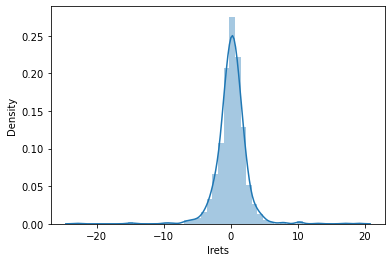

In [16]:
sns.distplot(NVR['lrets'].dropna())


In [17]:
def GARCH(Y):
    "Initialize Params:"
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T) 
    sigma2 = np.zeros(T)   
    F = np.zeros(T)   
    v = np.zeros(T)   
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])     
        Likelihood = np.sum(GARCH_Dens[1:-1])  
    return Likelihood

In [49]:
def GARCH_Prod(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    Y = np.zeros(T)  
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.0001
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
    return Y

         Current function value: 101.786375
         Iterations: 1
         Function evaluations: 116
         Gradient evaluations: 21


/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60385/4278608838.py:4: OptimizeWarning: Unknown solver options: xtol
  param_star=opt.minimize(GARCH,param0, method ='BFGS' , options = {'xtol' : 1e-8, 'disp' : True})


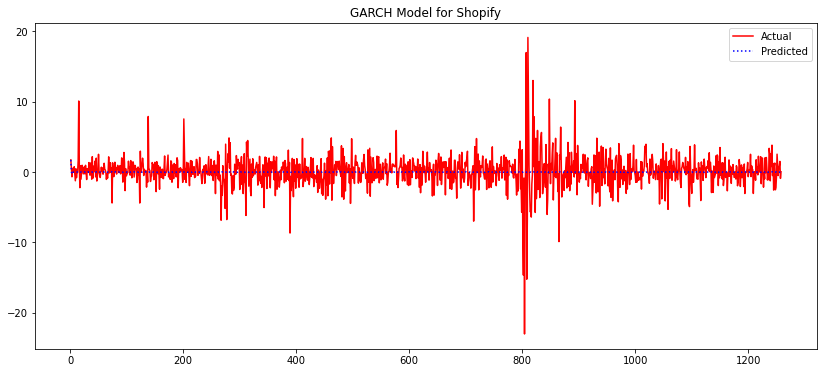

In [50]:
Y = NVR['lrets'].dropna()
T=len(Y)
param0=np.array([0,0.0003,0.09,0.02])
param_star=opt.minimize(GARCH,param0, method ='BFGS' , options = {'xtol' : 1e-8, 'disp' : True})

Y_GARCH=GARCH_Prod(param_star.x,Y[1],T)
timevec=np.linspace(1,T,T)

fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')

plt.legend(loc='upper right')
plt.title("GARCH Model for Shopify")
plt.show()


In [51]:
dif_NVR = pd.DataFrame({'Actual':list(Y),
                     'Predicted':list(Y_GARCH)})
dif_NVR


,Actual,Predicted
0,1.729217,1.729217
1,0.631206,-0.004315
2,-0.671126,-0.197751
3,0.202407,0.078911
4,0.561606,0.018731
...,...,...
1253,0.610788,-0.053332
1254,0.845212,-0.004834
1255,1.519370,-0.012964
1256,-0.898425,0.004443


In [52]:
rmse = sqrt(mean_squared_error(dif_NVR['Actual'],dif_NVR['Predicted']))
rmse


2.287131120695032

In [53]:
y_pred = [] * 1000

for i in range(len(dif_NVR)+1):
    if i == 0:
        y_pred.append(636.989990)
    else:
        y_pred.append(math.exp(dif_NVR['Predicted'][i-1]/100) * y_pred[i-1])

In [54]:
Predicted = pd.DataFrame({'Actual_Close_Price':NVR.Close,
                     'Predicted_Close_Price':list(y_pred),
                         'Date': NVR.Date})
Predicted.set_index('Date')


,Actual_Close_Price,Predicted_Close_Price
Date,,
2017-01-03,1649.989990,636.989990
2017-01-04,1678.770020,648.100718
2017-01-05,1689.400024,648.072756
2017-01-06,1678.099976,646.792452
2017-01-09,1681.500000,647.303043
...,...,...
2021-12-27,5820.069824,651.901175
2021-12-28,5869.470215,651.869662
2021-12-29,5959.330078,651.785158


Checking Return Volatility with Actual and Predicted Values¶


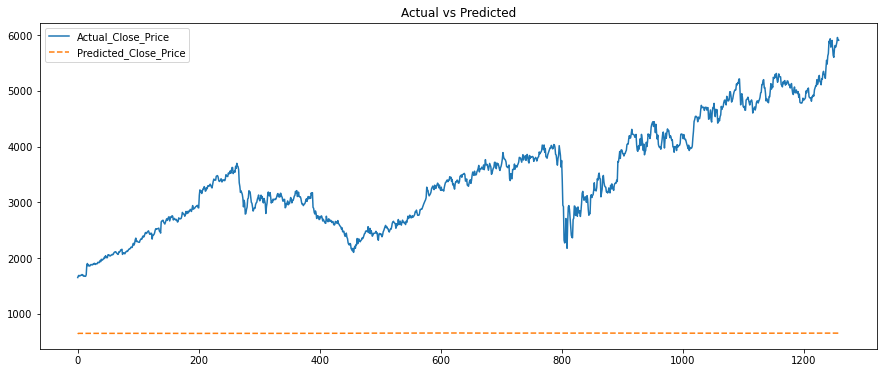

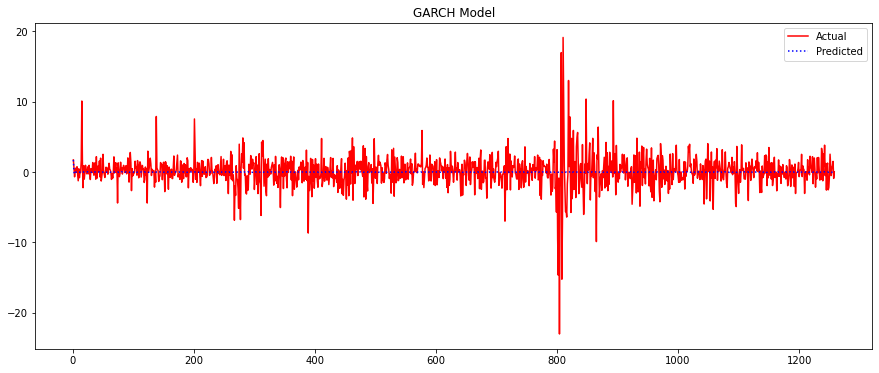

In [55]:
Predicted[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,6), style=['-','--'], 
                                                                    title = 'Actual vs Predicted')
fig= plt.figure(figsize=(15,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("GARCH Model")
plt.show()

In [56]:
Predicted.tail()


,Actual_Close_Price,Predicted_Close_Price,Date
1254,5820.069824,651.901175,2021-12-27
1255,5869.470215,651.869662,2021-12-28
1256,5959.330078,651.785158,2021-12-29
1257,5906.029785,651.814119,2021-12-30
1258,5908.870117,651.950139,2021-12-31


Trading Strategy
 <br>
1.Buy if we have next days predicted_value greater than todays close value and hold if already bought<br>
2.Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1


In [57]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(Predicted)-1):
    if Predicted['Predicted_Close_Price'][i+1] > Predicted['Actual_Close_Price'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / Predicted['Actual_Close_Price'][i])
            balance = int(amount % Predicted['Actual_Close_Price'][i])
            portfolio = stocks * Predicted['Actual_Close_Price'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',Predicted['Actual_Close_Price'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * Predicted['Actual_Close_Price'][i]
            amount = portfolio + balance
            print('Stock:',Predicted['Actual_Close_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif Predicted['Predicted_Close_Price'][i+1] < Predicted['Actual_Close_Price'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * Predicted['Actual_Close_Price'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',Predicted['Actual_Close_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',Predicted['Actual_Close_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')

Stock: 1649.989990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 1678.77001953125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 1689.4000244140625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 1678.0999755859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 1681.5 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 1690.969970703125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 1690.760009765625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 1703.6300048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 1700.0 Action: Price-Prediction-Already-Lo

Stock: 2645.360107421875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2659.330078125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2720.85009765625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2708.2099609375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2704.949951171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2704.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2712.699951171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2751.699951171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2818.989990234375 Action: Price-Prediction-Already

Stock: 3174.219970703125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3090.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2988.02001953125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3022.39990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2999.989990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3057.330078125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3041.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3052.22998046875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3058.360107421875 Action: Price-Prediction-Already-Lower Port

Stock: 2365.679931640625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2401.280029296875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2435.330078125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2444.18994140625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2482.5400390625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2485.840087890625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2484.1201171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2468.760009765625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 2562.7099609375 Action: Price-Prediction-

Stock: 3367.75 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3396.3798828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3396.4599609375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3348.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3343.31005859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3371.0400390625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3468.14990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3468.679931640625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3489.6298828125 Action: Price-Prediction-Already-Lower Portfol

Stock: 3952.2099609375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3981.860107421875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3976.780029296875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 4021.75 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3993.6298828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3960.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3965.949951171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 4037.77001953125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 4031.139892578125 Action: Price-Prediction-Already-Lower Po

Stock: 4033.300048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3931.2900390625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 4044.52001953125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3853.14990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3909.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 3930.510009765625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 4078.550048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 4001.56005859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 4083.1201171875 Action: Price-Prediction-Already-



Stock: 5018.10009765625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5124.06982421875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5104.9501953125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5142.419921875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5134.43994140625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5211.3798828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5215.81005859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 4988.02978515625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 4749.3701171875 Action: Price-Prediction-Al

Stock: 5671.3798828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5892.580078125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5863.52001953125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5935.72021484375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5785.89990234375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5832.0498046875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5907.3701171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5760.35009765625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 5636.77978515625 Action: Price-Prediction-Alre

In [58]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':NVR.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': NVR.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()


,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,1678.770020,648.100718,2017-01-04,Price-Prediction-Already-Lower,0,0,10000
2,1689.400024,648.072756,2017-01-05,Price-Prediction-Already-Lower,0,0,10000
3,1678.099976,646.792452,2017-01-06,Price-Prediction-Already-Lower,0,0,10000
4,1681.500000,647.303043,2017-01-09,Price-Prediction-Already-Lower,0,0,10000
5,1690.969971,647.424304,2017-01-10,Price-Prediction-Already-Lower,0,0,10000


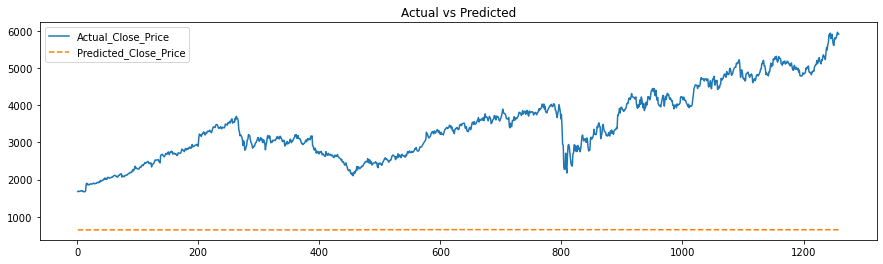

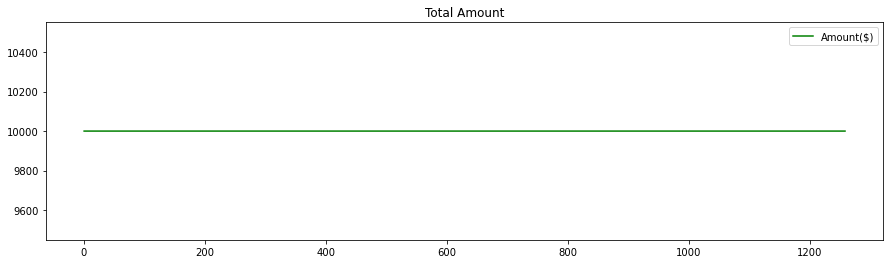

In [59]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')



Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')


In [60]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')


Initial_Investment : 10000$
Final Amount: 10000 $
Profit_Percent: 100.0 %


In [61]:
rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))
rms


2956.2842378457026

Sharp Ratio

In [62]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [63]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0 0.0


/var/folders/q_/k453wb756qb6rg_z6dc5p9fr0000gn/T/ipykernel_60385/2390669561.py:7: RuntimeWarning: invalid value encountered in double_scalars
  Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd


nan

In [64]:
rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))


In [65]:
sqrt(rms)


54.37172277798178